In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

### 

In [2]:
df = pd.read_csv('data/train.csv')
allfeats=pd.read_csv('all_featsv5.csv')
df = df.merge(allfeats, on='id')

In [3]:
cols=['v','vol','pressure', 'u_in', 'R', 'C', 'time_step',"step_id", 'id', 'breath_id']
"""
due to long computation times for the (auto-) correlation function, we reduce the data to 80 breaths
"""

data = df[cols].query('breath_id<80')
data = data.reset_index(drop=True)

splitpoint = data.query('breath_id==79').index.min()
end_point = data.query('breath_id==79').index.max()

# calculate splitpoint by breath
#print(data.breath_id.max())
#splitpoint = data[data['breath_id']==data.breath_id.max()].id.min()

data_train, data_test = data.loc[:splitpoint], data.loc[splitpoint:]
X_train, y_train = data_train.drop('pressure', axis=1), data_train.pressure
X_test, y_test = data_test.drop('pressure', axis=1), data_test.pressure

In [4]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

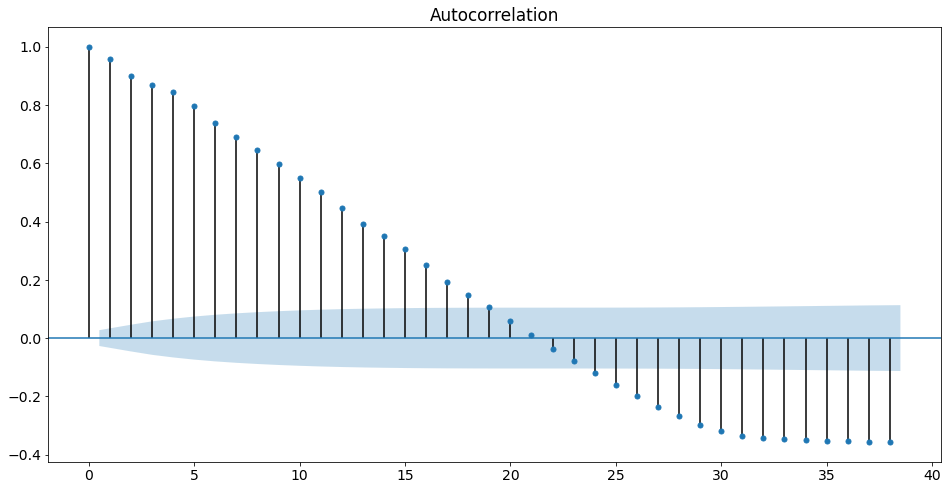

In [5]:
plot_acf(data.pressure)
plt.show()

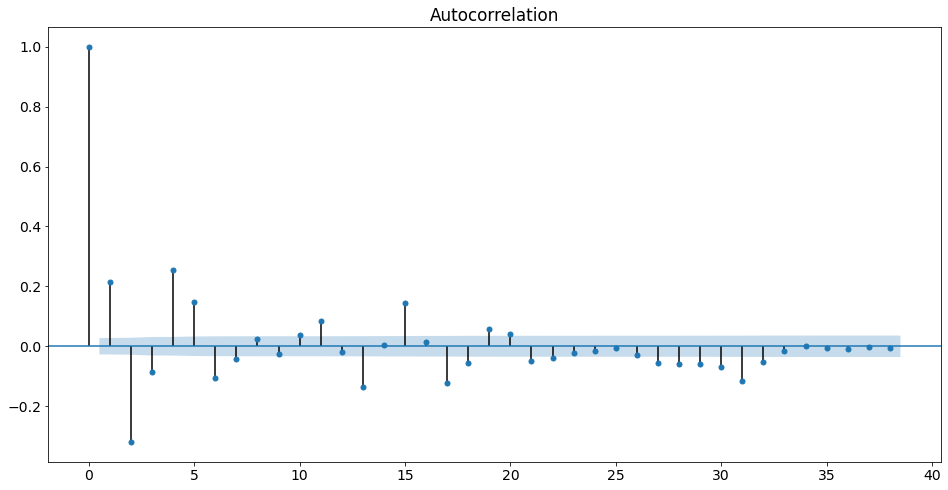

In [6]:
plot_acf(difference(data.pressure,1))
plt.show()

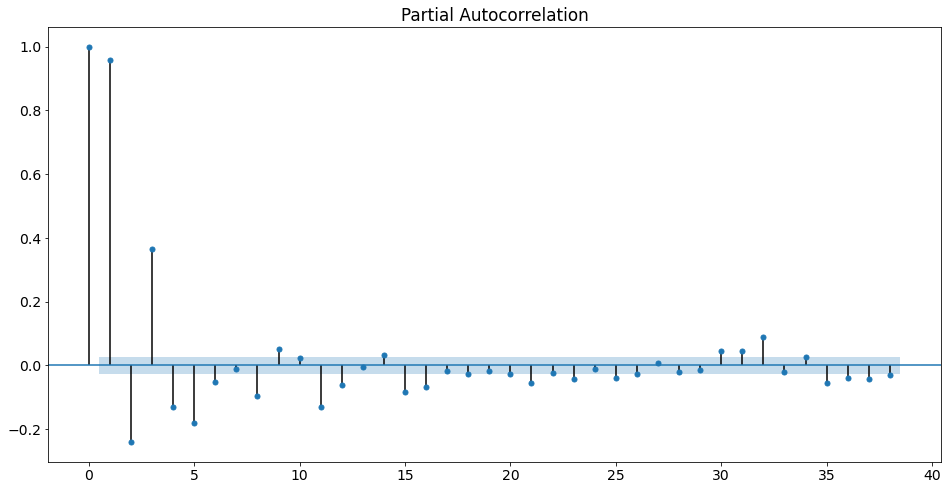

In [7]:
plot_pacf(data.pressure)
plt.show()

### stationarity of the pressure as a time series
Here we apply 3 different tests to check if the pressure is stationary and have a look at the time derivative additionally

In [8]:
## check stationarity with augmented dickey fuller test on logarithmic pressure data
adf_result = adfuller(data.pressure)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.593334
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


a p value of zero means that we reject the null hypothesis. in this case the null hypothesis is that there is a unit root present in the data, i.e. the series is not stationary.
thus we conclude that the series is stationary

In [9]:
_stat, p_value, _, critical_values = kpss(data.pressure)

#print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Stationary") if p_value > 0.05 else print("Non-Stationary")

Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [10]:
## Zivot-Andrews test
# strangely, the autolag values 'AIC' and 'BIC' are not working. that is why 't-stat' is chosen here.
t_stat, p_value, critical_values, _, _ = zivot_andrews(data.pressure, maxlag=10, regression='ct', autolag='t-stat')
print(f'Zivot-Andrews Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

Zivot-Andrews Statistic: -13.73
Critial Values:
   1%, -5.58
Critial Values:
   5%, -5.07
Critial Values:
   10%, -4.83

p-value: 0.00
Stationary


All of the 3 tests suggest that the null hypothesis can be rejected and thus the pressure can be assumed to be stationary.

### stationarity of the time derivative(s) of the pressure

In [11]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [12]:
## check stationarity with augmented dickey fuller test on logarithmic pressure data
adf_result = adfuller(difference(data.pressure))
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.398528
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [13]:
_stat, p_value, _, critical_values = kpss(difference(data.pressure))

#print(f'ADF Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Stationary") if p_value > 0.05 else print("Non-Stationary")

Critial Values:
   10%, 0.35
Critial Values:
   5%, 0.46
Critial Values:
   2.5%, 0.57
Critial Values:
   1%, 0.74

p-value: 0.10
Stationary


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [14]:
## Zivot-Andrews test
# strangely, the autolag values 'AIC' and 'BIC' are not working. that is why 't-stat' is chosen here.
t_stat, p_value, critical_values, _, _ = zivot_andrews(difference(data.pressure), maxlag=10, regression='ct', autolag='t-stat')
print(f'Zivot-Andrews Statistic: {t_stat:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'   {key}, {value:.2f}')

print(f'\np-value: {p_value:.2f}')
print("Non-Stationary") if p_value > 0.05 else print("Stationary")

Zivot-Andrews Statistic: -19.60
Critial Values:
   1%, -5.58
Critial Values:
   5%, -5.07
Critial Values:
   10%, -4.83

p-value: 0.00
Stationary


### forecasting with the arima model

#### now create enlarged data to fit with more features

## out of sample prediction

### for one parameter combination

In [15]:
nr_b = 101
nr_test = 10

R5C50 = df.query('R==5 & C==50')
dataset1 = R5C50.reset_index()

train_data1 = dataset1.reset_index().loc[:(nr_b-nr_test)*80-1]
test_data1 = dataset1.reset_index().loc[(nr_b-nr_test)*80:nr_b*80-1]

X_train1, y_train1 = train_data1.drop('pressure', axis=1), train_data1.pressure
X_test1, y_test1 = test_data1.drop('pressure', axis=1), test_data1.pressure

In [16]:
model_1 = ARIMA(endog=y_train1, exog=X_train1, order=(3,1,5))
model_1_fit = model_1.fit()

In [17]:
model_1_fit.predict()

0       274917.045129
1            7.031028
2            8.201779
3            9.181941
4            9.408654
            ...      
7275         4.826594
7276         5.069210
7277         5.010946
7278         5.123670
7279         5.115890
Length: 7280, dtype: float64

The first predicted value is extermely large because there are no previous values as inputs. By reagrding the dataset as continous data, this problem does not occur for the out of sample prediction.

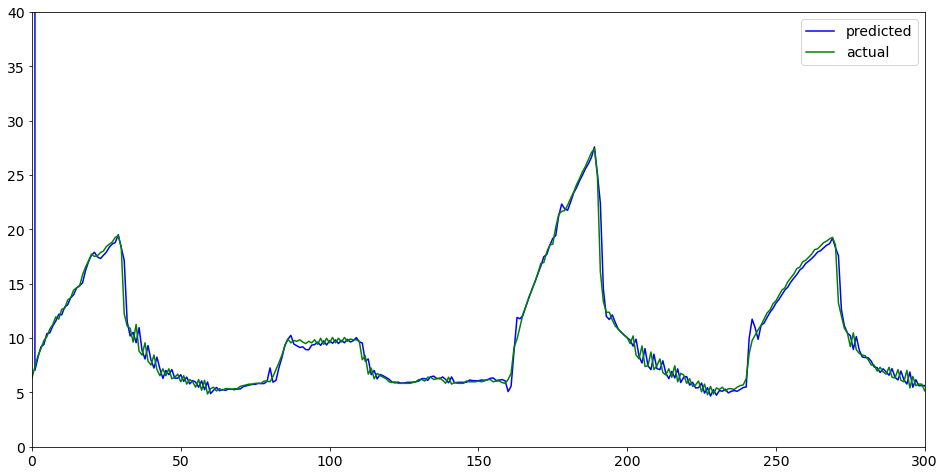

In [18]:
plt.plot(np.arange(0,7280,1),model_1_fit.predict(), 'b')
plt.plot(np.arange(0,7280,1),y_train1, 'g')

plt.ylim(0,40)
plt.xlim(0,300)

plt.legend(['predicted', 'actual'])

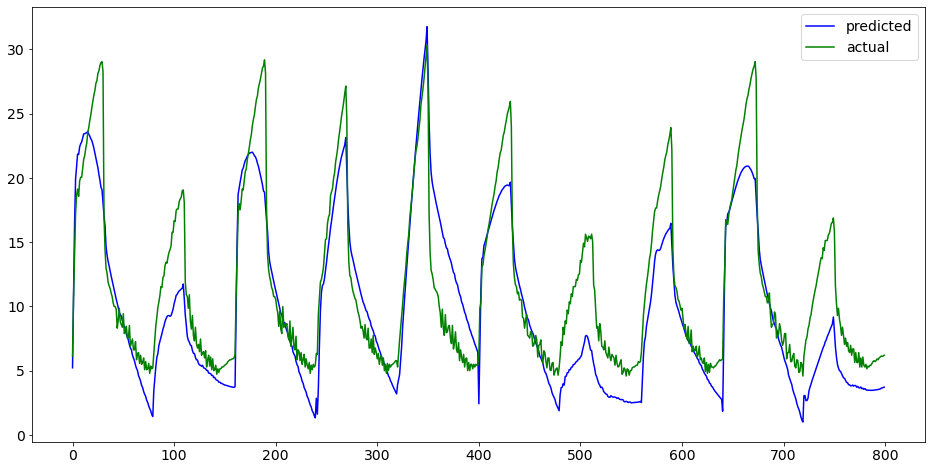

In [19]:
plt.plot(np.arange(0,800,1),model_1_fit.predict(exog = X_test1, start = 7280, end = 8079), 'b')
plt.plot(np.arange(0,800,1),y_test1, 'g')

plt.legend(['predicted', 'actual'])

In [20]:
# grid search for all features

ps = np.arange(1, 7, 1)
ds = np.arange(1, 4, 1)
qs = np.arange(1, 7, 1)

b_mean = 10000000000
for p in ps:
    for d in ds:
        for q in qs:
            model_1 = ARIMA(endog=y_train1, exog=X_train1, order=(p,d,q))
            model_1_fit = model_1.fit()
            pred = model_1_fit.predict(exog = X_test1, start = 7280, end = 8079).to_list()
            new_pred = []
            for i in range(len(pred)):
                if pred[i]>=0:
                    new_pred.append(pred[i])
                else:
                    new_pred.append(0.)
            new_mean=mean_absolute_error(new_pred, y_test1)
            if new_mean<b_mean:
                bestparams=[p,d,q]
                b_mean=new_mean

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\stat

In [21]:
bestparams

[2, 1, 4]

In [22]:
b_mean

2.464567096456742

In [23]:
model_1_imp = ARIMA(endog=y_train1, exog=X_train1, order=(2,1,4))
model_1_imp_fit = model_1_imp.fit()

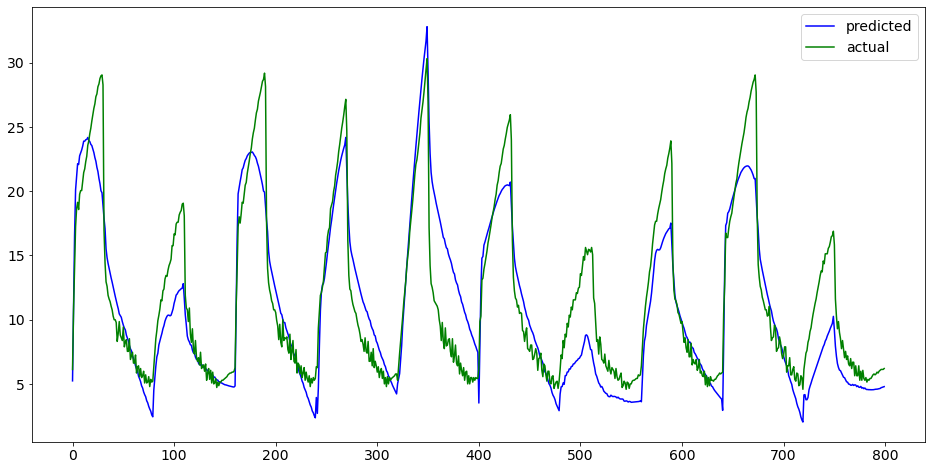

In [24]:
plt.plot(np.arange(0,800,1),model_1_imp_fit.predict(exog = X_test1, start = 7280, end = 8079), 'b')
plt.plot(np.arange(0,800,1),y_test1, 'g')

plt.legend(['predicted', 'actual'])

#### using ARIMA model on unhealthy lung parameters

In [25]:
nr_b = 101
nr_test = 10

R50C10 = df.query('R==50 & C==10')
dataset2 = R50C10.reset_index()

train_data2 = dataset2.reset_index().loc[:(nr_b-nr_test)*80-1]
test_data2 = dataset2.reset_index().loc[(nr_b-nr_test)*80:nr_b*80-1]

X_train2, y_train2 = train_data2.drop('pressure', axis=1), train_data2.pressure
X_test2, y_test2 = test_data2.drop('pressure', axis=1), test_data2.pressure

In [26]:
model_2 = ARIMA(endog=y_train2, exog=X_train2, order=(3,1,5))
model_2_fit = model_2.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


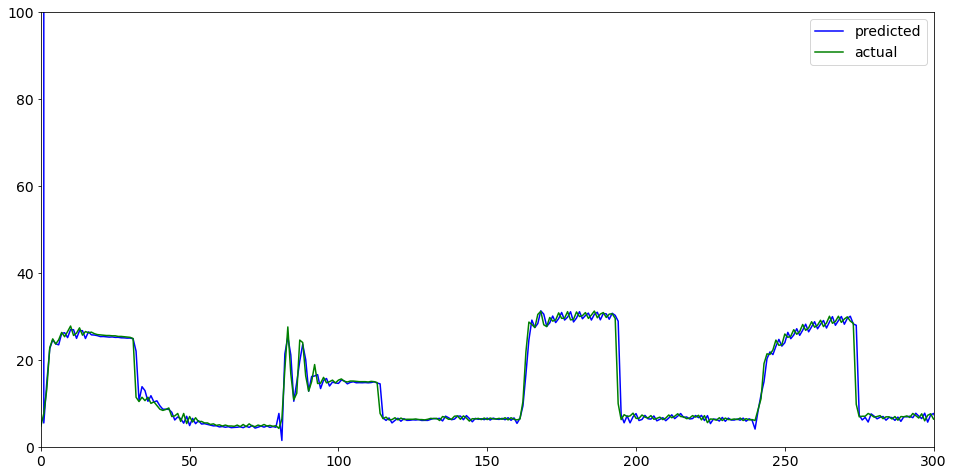

In [27]:
plt.plot(np.arange(0,7280,1),model_2_fit.predict(), 'b')
plt.plot(np.arange(0,7280,1),y_train2, 'g')

plt.ylim(0,100)
plt.xlim(0,300)

plt.legend(['predicted', 'actual'])

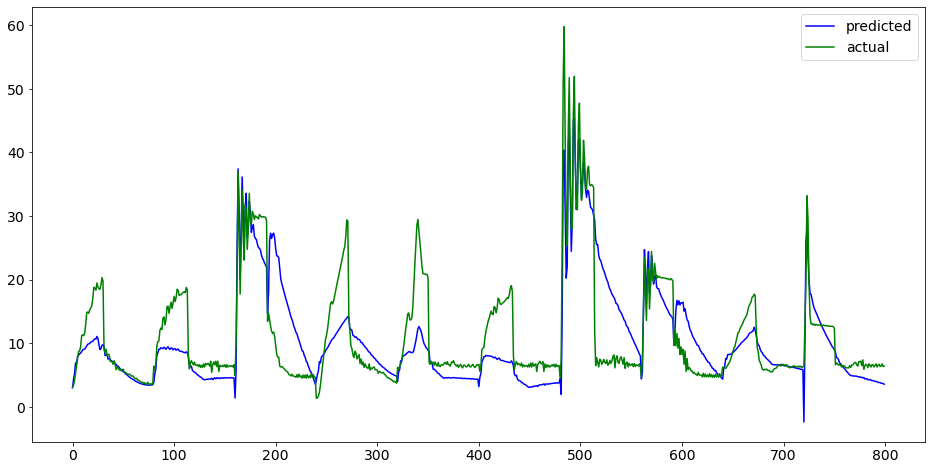

In [28]:
plt.plot(np.arange(0,800,1),model_2_fit.predict(exog = X_test2, start = 7280, end = 8079), 'b')
plt.plot(np.arange(0,800,1),y_test2, 'g')

plt.legend(['predicted', 'actual'])

In [29]:
# grid search for all features

ps = np.arange(1, 7, 1)
ds = np.arange(1, 4, 1)
qs = np.arange(1, 7, 1)

negcount = 0
b_mean = 10000000000
for p in ps:
    for d in ds:
        for q in qs:
            model_2 = ARIMA(endog=y_train2, exog=X_train2, order=(p,d,q))
            model_2_fit = model_2.fit()
            pred = model_2_fit.predict(exog = X_test2, start = 7280, end = 8079).to_list()
            new_pred = []
            for i in range(len(pred)):
                if pred[i]>=0:
                    new_pred.append(pred[i])
                else:
                    new_pred.append(0.)
                    negcount+=1
            new_mean=mean_absolute_error(new_pred, y_test2)
            if new_mean<b_mean:
                bestparams=[p,d,q]
                b_mean=new_mean

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\mod

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Ma

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: Us

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stat

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Ma

In [30]:
bestparams, b_mean, negcount

([3, 1, 5], 3.85759574608956, 29337)

We see that the performance of the ARIMA model on unhealthy lung parameters R=50, C=10 is way worse than for R=5, C=50. This is probably due to larger variations of the pressure in that case. Another insight of the calculations above is the fact that the order parameter set (3,1,5) gives the best results for both parameter combinations regarded. Now lets have a look at the performance on all resistance, compliance combinations with the order parameters determined above.

### for all parameter combinations

In [31]:
nr_b = 201 # number of breaths in total
nr_test = 20 # number of test breaths

dataset3 = df

train_data3 = dataset3.reset_index().loc[:(nr_b-nr_test)*80-1]
test_data3 = dataset3.reset_index().loc[(nr_b-nr_test)*80:nr_b*80-1]

X_train3, y_train3 = train_data3.drop('pressure', axis=1), train_data3.pressure
X_test3, y_test3 = test_data3.drop('pressure', axis=1), test_data3.pressure

In [32]:
model_3 = ARIMA(endog=y_train3, exog=X_train3, order=(3,1,5))
model_3_fit = model_3.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


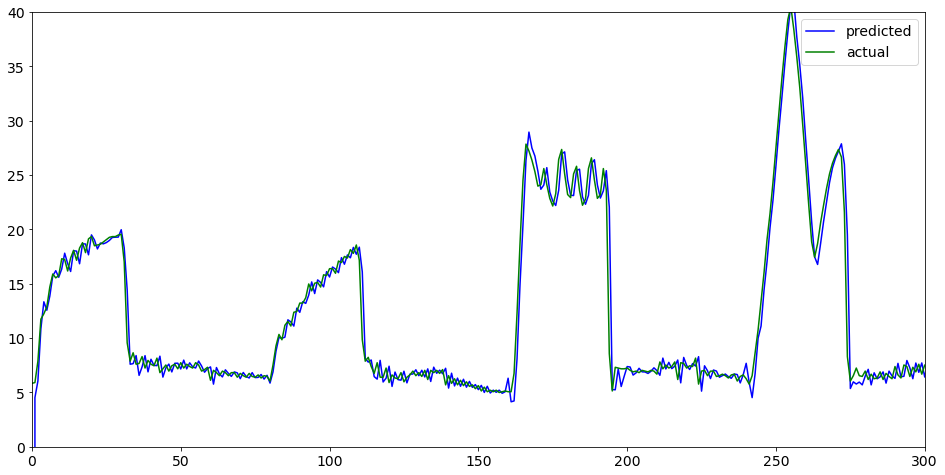

In [33]:
plt.plot(np.arange(0,14480,1),model_3_fit.predict(), 'b')
plt.plot(np.arange(0,14480,1),y_train3, 'g')

plt.ylim(0,40)
plt.xlim(0,300)

plt.legend(['predicted', 'actual'])

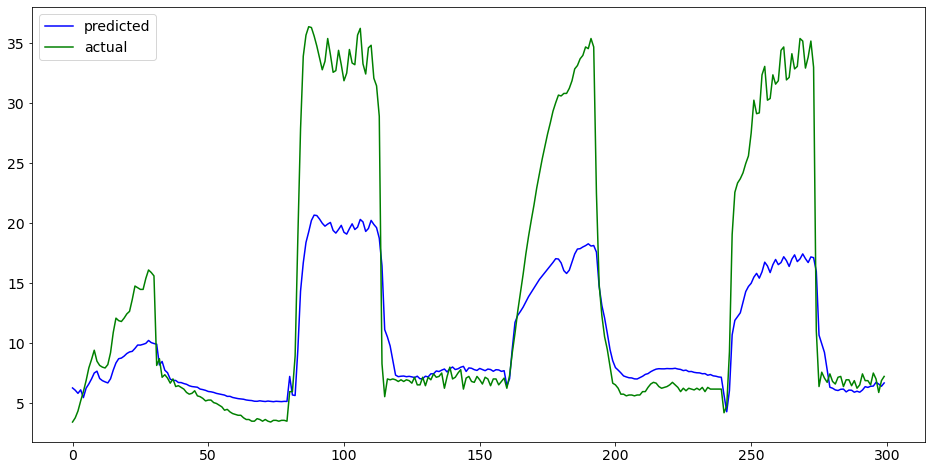

In [34]:
plt.plot(np.arange(0,300,1),model_3_fit.predict(exog = X_test3, start = 14480, end = 16079)[:300], 'b')
plt.plot(np.arange(0,300,1),y_test3[:300], 'g')

plt.legend(['predicted', 'actual'])

In [35]:
mean_absolute_error(model_3_fit.predict(exog = X_test3, start = 14480, end = 16079), y_test3)

4.027570099114339

In [36]:
def error_analysis(y_test, y_pred_test):
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#105722", alpha=0.7)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#105722", alpha=0.7)
    ax[1].plot([y_test.min(), y_test.max()], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

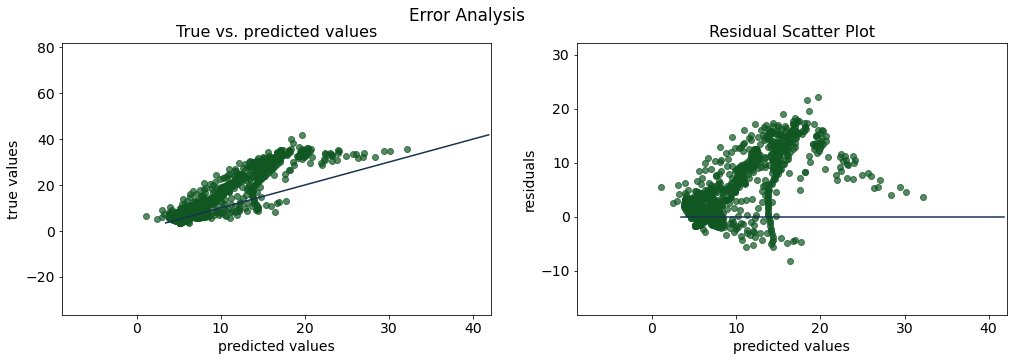

In [37]:
error_analysis(y_test3, model_3_fit.predict(exog = X_test3, start = 14480, end = 16079))

Looking at the error plots above, there are clear patterns in the residual plot and the errors are not normally distributed. This hints to an underfitting of our model which is certainly due to the limited flexibility of it (the ARIMA model is based on linear regression). To get better reults it is necessary to use a more complex approach.